In [152]:
import glob
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import sklearn.preprocessing as preproc
import sklearn.linear_model as lm
import sklearn.pipeline
from scipy.optimize import least_squares
from IPython.display import Image
%matplotlib inline

In [2]:
def load_registration_data(path = 'data/SOS/processed/voter-registration.csv'):
    df = pd.read_csv(path,header=[0,1],index_col=[0,1])
    dtIdx = pd.DatetimeIndex(df.columns.get_level_values(0))
    col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.columns.get_level_values(1)])
    df.columns = col_mIdx
    df.sort_index(inplace=True,axis=1,level=[0,1])
    df.sort_index(axis=1,level=[0,1],inplace=True)
    df.sort_index(axis=0,level=[0,1],inplace=True)
    return df

def load_prop_data(path = 'data/SOS/processed/measures.csv'):
    df = pd.read_csv(path,header=[0,1,2],index_col=0)
    dtIdx = pd.DatetimeIndex(df.columns.get_level_values(0))
    col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.columns.get_level_values(1),df.columns.get_level_values(2)])
    df.columns = col_mIdx
    df.sort_index(inplace=True,axis=1,level=[0,1])
    return df

def load_prop_metadata(path = 'data/SOS/processed/measures_metadata.csv'):
    df = pd.read_csv(path,header=0,index_col=[0,1])
    dtIdx = pd.DatetimeIndex(df.index.get_level_values(0))
    row_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.index.get_level_values(1)])
    df.index = row_mIdx
    df.sort_index(inplace=True,axis=0)
    return df

In [3]:
df_reg = load_registration_data()
df_prop = load_prop_data()
df_prop_meta = load_prop_metadata()

In [4]:
df_reg

Date                      2001-10-02                                     \
Category                   All Other American Independent    Democratic   
County       Count_type                                                   
Alameda      Count        12807.0000           10902.0000  3.777450e+05   
             Fraction         0.0192               0.0163  5.652000e-01   
Alpine       Count           11.0000              25.0000  2.710000e+02   
             Fraction         0.0141               0.0322  3.488000e-01   
Amador       Count          369.0000             515.0000  7.352000e+03   
             Fraction         0.0199               0.0277  3.950000e-01   
Butte        Count         1593.0000            3116.0000  4.104100e+04   
             Fraction         0.0142               0.0278  3.664000e-01   
Calaveras    Count          290.0000             646.0000  9.277000e+03   
             Fraction         0.0116               0.0260  3.738000e-01   
Colusa       Count           51.0000             200.0000  3.044000e+03   
             Fraction         0.0068               0.0266  4.054000e-01   
Contra Costa Count        20252.0000            8349.0000  2.356120e+05   
             Fraction         0.0425               0.0175  4.940000e-01   
Del Norte    Count          164.0000             439.0000  4.889000e+03   
             Fraction         0.0130               0.0348  3.877000e-01   
El Dorado    Count         1147.0000            2336.0000  3.070600e+04   
             Fraction         0.0128               0.0260  3.416000e-01   
Fresno       Count         2391.0000            6419.0000  1.370740e+05   
             Fraction         0.0073               0.0197  4.201000e-01   
Glenn        Count           91.0000             311.0000  4.298000e+03   
             Fraction         0.0079               0.0270  3.725000e-01   
Humboldt     Count          912.0000            1931.0000  3.186000e+04   
             Fraction         0.0120               0.0255  4.205000e-01   
Imperial     Count          656.0000            1066.0000  2.515600e+04   
             Fraction         0.0138               0.0224  5.287000e-01   
Inyo         Count          114.0000             293.0000  3.451000e+03   
             Fraction         0.0113               0.0291  3.429000e-01   
Kern         Count         2441.0000            7765.0000  1.008960e+05   
             Fraction         0.0089               0.0285  3.702000e-01   
...                              ...                  ...           ...   
Shasta       Count          631.0000            2460.0000  2.887100e+04   
             Fraction         0.0075               0.0293  3.438000e-01   
Sierra       Count           41.0000              77.0000  7.960000e+02   
             Fraction         0.0179               0.0335  3.462000e-01   
Siskiyou     Count          254.0000             773.0000  9.835000e+03   
             Fraction         0.0100               0.0307  3.911000e-01   
Solano       Count         2001.0000            3759.0000  9.062900e+04   
             Fraction         0.0112               0.0211  5.091000e-01   
Sonoma       Count         3289.0000            4618.0000  1.207280e+05   
             Fraction         0.0138               0.0193  5.049000e-01   
Stanislaus   Count         3050.0000            4685.0000  8.748200e+04   
             Fraction         0.0148               0.0227  4.234000e-01   
State Total  Count       256528.0000          310839.0000  6.940276e+06   
             Fraction         0.0167               0.0203  4.525000e-01   
Sutter       Count         1334.0000             847.0000  1.289100e+04   
             Fraction         0.0365               0.0232  3.529000e-01   
Tehama       Count          341.0000             974.0000  1.048100e+04   
             Fraction         0.0127               0.0363  3.908000e-01   
Trinity      Count          166.0000             237.0000  2.920000e+03   
             Fraction    

In [5]:
df_prop

Date                2002-03-05                                   \
Proposition     Proposition_40          Proposition_41            
Votes                       No      Yes             No      Yes   
Alameda                  74228   142873          81464   130697   
Alpine                     256      281            296      233   
Amador                    5883     3605           5888     3573   
Butte                    25178    21833          24582    24682   
Calaveras                 7642     4923           7642     4763   
Colusa                    2931     1322           2679     1518   
Contra Costa             74344   103748          79849    95390   
Del Norte                 3625     1903           3419     2052   
El Dorado                24884    16872          25075    16173   
Fresno                   53206    53571          50762    54034   
Glenn                     3706     1155           3225     1579   
Humboldt                 16576    15093          16216    14875   
Imperial                  7478     9210           8560     7768   
Inyo                      3297     2217           3100     2305   
Kern                     50046    37754          57589    43359   
Kings                     8046     5821           7932     5755   
Lake                      5881     5372           6102     4988   
Lassen                    5065     2351           4622     2766   
Los Angeles             347804   633273         414154   536127   
Madera                   12143     6565          11473     7068   
Marin                    19960    42222          22778    38257   
Mariposa                  3389     2041           3356     2009   
Mendocino                 7298     8709           9841     9232   
Merced                   14019    12509          14501    12094   
Modoc                     2416      735           2085     1028   
Mono                      1336     1048           1330     1034   
Monterey                 24857    34555          29173    28865   
Napa                     11144    15315          11884    14062   
Nevada                   17307    12884          17329    12199   
Orange                  216770   270153         264208   208619   
Placer                   39972    28446          40883    26942   
Plumas                    4592     2375           4050     2855   
Riverside                79428    96961          85048    94644   
Sacramento               99742   111800         110100    99983   
San Benito                4304     4767           4601     4277   
San Bernardino           79307    84686          83797    77362   
San Diego               191832   233412         209148   207088   
San Francisco            31184   111530          37935   101611   
San Joaquin              43571    43405          45385    40223   
San Luis Obispo          29788    26212          30345    24732   
San Mateo                40094    73921          43941    67588   
Santa Barbara            35037    35126          35937    33007   
Santa Clara              90006   141914         101621   126060   
Santa Cruz               18756    36009          25112    33665   
Shasta                   25445    11588          23512    12911   
Sierra                     973      473            950      478   
Siskiyou                  9035     3285           7978     4265   
Solano                   27106    31100          28281    28615   
Sonoma                   43125    67883          48284    60858   
Stanislaus               34362    35358          37444    31053   
Sutter                    8786     4216           8617     4287   
Tehama                    9124     4601           8764     4806   
Trinity                   3037     1392           2805     1565   
Tulare                   27644    16515          25599    18949   
Tuolumne                  7673     5852           7539     5717   
Ventura                  53433    69671          60585    60059   
Yolo                     14358    20185        

In [6]:
df_prop_meta

Description  \
Date       Proposition                                                          
2002-03-05 Proposition_40       Clean Water/Air, Safe Parks, Coast Protection   
           Proposition_41               Voting Modernization Bond Act of 2002   
           Proposition_42      Transportation Funding: Sales/Use Tax Revenues   
           Proposition_43                          Right to have vote counted   
           Proposition_44                                     Insurance Fraud   
           Proposition_45     Legislative Term Limits. Local Voter Petitions.   
2002-11-05 Proposition_46            Housing and Emergency Shelter Trust Fund   
           Proposition_47             Kindergarten-University Facilities Bond   
           Proposition_48                                 Court Consolidation   
           Proposition_49                 After School Programs. State Grants   
           Proposition_50     Water Quality, Supply/Safe Drinking Water Bonds   
           Proposition_51   Transportation. Allocation of Motor Vehicle Taxes   
           Proposition_52                     Election Day Voter Registration   
2003-10-07 Proposition_53                             Infrastructure: Finance   
           Proposition_54         Classification by Race, ... Color or Origin   
2004-03-02 Proposition_55                                      Education Bond   
           Proposition_56                                        State Budget   
           Proposition_57                              Economic Recovery Bond   
           Proposition_58                                     Balanced Budget   
2004-11-02 Proposition_1A             Protection of Local Government Revenues   
           Proposition_59                       Public Records, Open Meetings   
           Proposition_60                Election Rights of Political Parties   
           Proposition_60A                                  Surplus Property.   
           Proposition_61        Children's Hospital Projects. Grant Program.   
           Proposition_62                                Elections. Primaries   
           Proposition_63                   Mental Health Services Expansion.   
           Proposition_64      Limits on Private Enforcement of Business Laws   
           Proposition_65    Local Government Funds, Revenues. State Mandates   
           Proposition_66                  Limitations on "Three Strikes" Law   
           Proposition_67                Emergency Medical Services. Funding.   
...                                                                       ...   
2012-11-06 Proposition_37               Genetically Engineered Foods Labeling   
           Proposition_38         Tax for Education. Early Childhood Programs   
           Proposition_39                     Business Tax for Energy Funding   
           Proposition_40                         Redistricting State\nSenate   
2014-06-03 Proposition_41      Veterans Housing\n& Homeless\nBond Act of 2014   
           Proposition_42    Public Records.\nOpen Meetings.\nReimbursements.   
2014-11-04 Proposition_1    Funding Water Quality, \nSupply, Treatment,\n ...   
           Proposition_2                  State Budget\nStabilization Account   
           Proposition_45                 Healthcare\nInsurance Rate\nChanges   
           Proposition_46           Doctor Drug Testing,\nMedical\nNegligence   
           Proposition_47         Criminal Sentences,\nMisdemeanor\nPenalties   
           Proposition_48                   Indian Gaming Compacts Referendum   
2016-06-07 Proposition_50                        Suspension \nof Legislators.   
2016-11-08 Proposition_51               K-12 and Community College Facilities   
           Proposition_52                       Medi-Cal Hospital Fee Program   
           Proposition_53                   Voter Approval of \nRevenue Bonds   
           Proposition_54                  Legislative Procedure Requirements   
           Propo

Date
2001-10-02    0.717900
2002-01-04    0.710300
2002-02-04    0.708700
2002-02-19    0.710500
2002-10-07    0.707100
2002-10-21    0.712900
2003-02-10    0.702600
2003-08-08    0.688400
2003-09-22    0.704500
2003-09-30    0.706800
2004-01-02    0.684200
2004-02-17    0.689500
2004-09-03    0.709100
2004-10-18    0.750000
2005-02-10    0.739200
2005-09-09    0.705600
2005-10-24    0.706700
2006-01-03    0.701100
2006-04-07    0.688000
2006-05-22    0.695100
2006-09-08    0.690300
2006-10-23    0.701100
2007-02-10    0.688800
2007-09-04    0.677700
2007-12-07    0.672900
2008-01-01    0.677700
2008-01-22    0.684700
2008-04-04    0.691100
2008-05-19    0.700000
2008-09-05    0.697900
2008-10-20    0.745600
2009-02-10    0.743900
2009-03-20    0.737900
2009-05-04    0.733500
2010-01-05    0.726100
2010-04-09    0.721200
2010-05-24    0.723900
2010-09-03    0.722400
2010-10-18    0.734000
2011-02-10    0.728100
2012-01-03    0.720140
2012-04-06    0.718700
2012-05-21    0.723400
2012-0

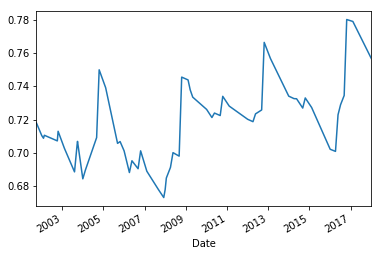

In [7]:
#df_reg.query('County == "State Total" & Count_type == "Fraction" & Category == "Total Registered"')
idx = pd.IndexSlice
reg_vs_time = df_reg.loc[idx['State Total','Fraction'],idx[:,'Total Registered']]
reg_vs_time.index = reg_vs_time.index.droplevel(level='Category')
print(reg_vs_time)
reg_vs_time.plot()

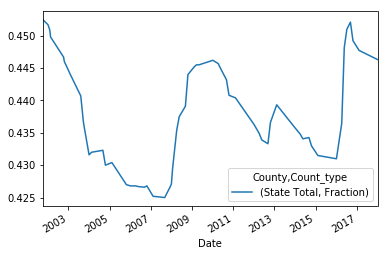

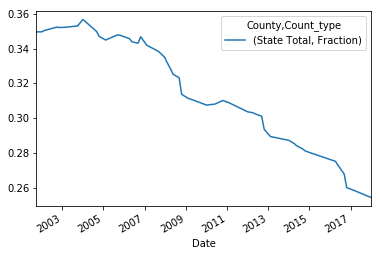

In [8]:
res = df_reg.xs(('State Total','Fraction'),level=('County','Count_type')).xs('Democratic',level='Category',axis=1)
res.T.plot()
res = df_reg.xs(('State Total','Fraction'),level=('County','Count_type')).xs('Republican',level='Category',axis=1)
res.T.plot()

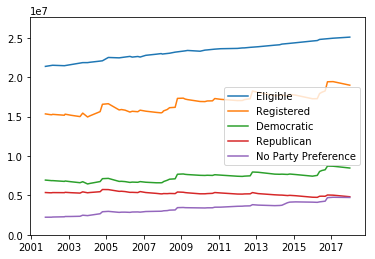

In [9]:
idx = pd.IndexSlice
county = 'State Total'
elg_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Eligible']]
reg_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Total Registered']]
dem_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Democratic']]
rep_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Republican']]
grn_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Green']]
npp_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'No Party Preference']]
x = elg_vs_time.index.get_level_values('Date')
y = elg_vs_time.values
plt.plot(x,y,label='Eligible')
y = reg_vs_time.values
plt.plot(x,y,label='Registered')
y = dem_vs_time.values
plt.plot(x,y,label='Democratic')
y = rep_vs_time.values
plt.plot(x,y,label='Republican')
# y = grn_vs_time.values
# plt.plot(x,y,label='Green')
y = npp_vs_time.values
plt.plot(x,y,label='No Party Preference')
plt.ylim(0,1.1*max(elg_vs_time.values))
plt.legend()

In [10]:
df_reg_frac = df_reg.loc[idx[:,'Fraction'],idx[:,'Total Registered']]
df_reg_frac.index = df_reg_frac.index.droplevel('Count_type')
df_reg_frac.columns = df_reg_frac.columns.droplevel('Category')

df_reg_frac.loc['Lake'][df_reg_frac.loc['Lake']>1]

Date
2008-04-04    4.1317
Name: Lake, dtype: float64

In [11]:
print(df_reg.loc[idx['Lake','Fraction'],idx['2008-04-04','Total Registered']])
print(df_reg.loc[idx['Lake','Count'],idx['2008','Eligible']])

Date        Category        
2008-04-04  Total Registered    4.1317
Name: (Lake, Fraction), dtype: float64
Date        Category
2008-01-01  Eligible    46454.0
2008-01-22  Eligible    46478.0
2008-04-04  Eligible     8024.0
2008-05-19  Eligible    46500.0
2008-09-05  Eligible    46714.0
2008-10-20  Eligible    46758.0
Name: (Lake, Count), dtype: float64


In [12]:
# impute (by eye for now) the value for the spurious entry
df_reg.loc[idx['Lake','Count'],idx['2008-04-04','Eligible']] = 46490
df_reg.loc[idx['Lake','Fraction'],idx['2008-04-04','Total Registered']] = (
    df_reg.loc[idx['Lake','Count'],idx['2008-04-04','Total Registered']].values / df_reg.loc[idx['Lake','Count'],idx['2008-04-04','Eligible']].values)

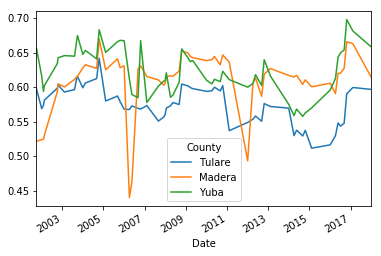

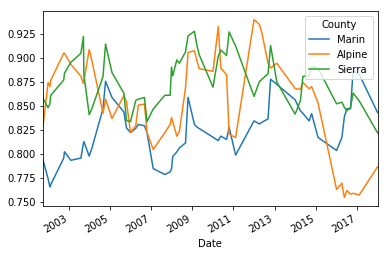

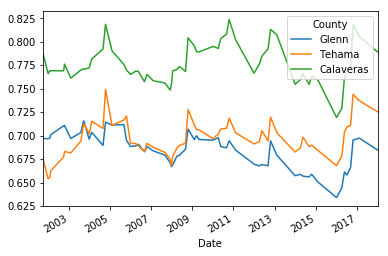

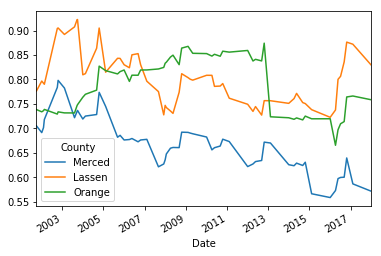

In [13]:
df_reg_frac = df_reg.loc[idx[:,'Fraction'],idx[:,'Total Registered']]
df_reg_frac.index = df_reg_frac.index.droplevel('Count_type')
df_reg_frac.columns = df_reg_frac.columns.droplevel('Category')
df_reg_frac = df_reg_frac.T
state_total = df_reg_frac.pop('State Total')
counties_sorted_mean_reg = df_reg_frac.mean().sort_values().index
# bottom 3 average registration rates
df_reg_frac[counties_sorted_mean_reg[:3]].plot()
# top 3 average registration rates
df_reg_frac[counties_sorted_mean_reg[-3:]].plot()

counties_sorted_std_reg = df_reg_frac.std().sort_values().index
# bottom 3 std registration rates
df_reg_frac[counties_sorted_std_reg[:3]].plot()
# top 3 std registration rates
df_reg_frac[counties_sorted_std_reg[-3:]].plot()


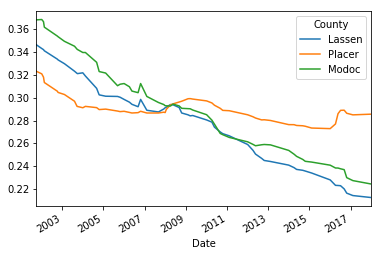

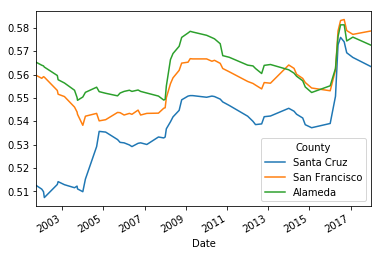

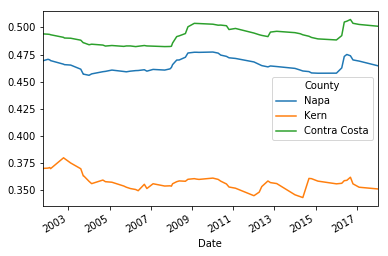

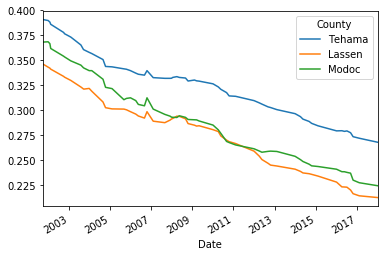

In [14]:
df_dem_frac = df_reg.loc[idx[:,'Fraction'],idx[:,'Democratic']]
df_dem_frac.index = df_dem_frac.index.droplevel('Count_type')
df_dem_frac.columns = df_dem_frac.columns.droplevel('Category')
df_dem_frac = df_dem_frac.T
state_total = df_dem_frac.pop('State Total')
counties_sorted_mean_reg = df_dem_frac.mean().sort_values().index
# bottom 3 average registration rates
df_dem_frac[counties_sorted_mean_reg[:3]].plot()
# top 3 average registration rates
df_dem_frac[counties_sorted_mean_reg[-3:]].plot()

counties_sorted_std_reg = df_dem_frac.std().sort_values().index
# bottom 3 std registration rates
df_dem_frac[counties_sorted_std_reg[:3]].plot()
# top 3 std registration rates
df_dem_frac[counties_sorted_std_reg[-3:]].plot()

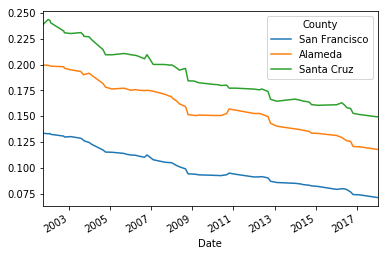

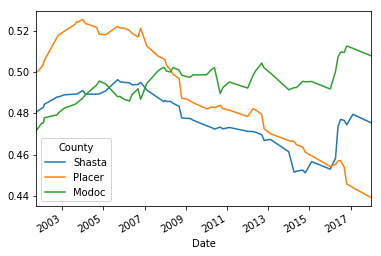

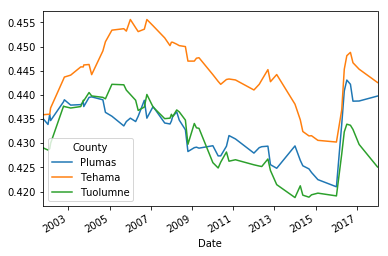

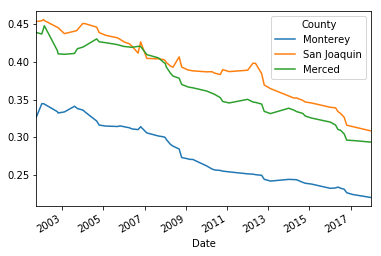

In [15]:
df_rep_frac = df_reg.loc[idx[:,'Fraction'],idx[:,'Republican']]
df_rep_frac.index = df_rep_frac.index.droplevel('Count_type')
df_rep_frac.columns = df_rep_frac.columns.droplevel('Category')
df_rep_frac = df_rep_frac.T
state_total = df_rep_frac.pop('State Total')
counties_sorted_mean_reg = df_rep_frac.mean().sort_values().index
# bottom 3 average registration rates
df_rep_frac[counties_sorted_mean_reg[:3]].plot()
# top 3 average registration rates
df_rep_frac[counties_sorted_mean_reg[-3:]].plot()

counties_sorted_std_reg = df_rep_frac.std().sort_values().index
# bottom 3 std registration rates
df_rep_frac[counties_sorted_std_reg[:3]].plot()
# top 3 std registration rates
df_rep_frac[counties_sorted_std_reg[-3:]].plot()

In [16]:
# date lookup table
df_prop_meta['nearest_reg_date']= np.nan # initialize column

# for all prop election dates, find closest (prior) voter registration dataset
for prop_date in df_prop_meta.index.levels[0]:
    reg_dates = df_reg.columns.levels[0]
    reg_dates_delta = pd.Series(prop_date - reg_dates, index=reg_dates)
    idx_closest_before = reg_dates_delta[reg_dates_delta>pd.to_timedelta(0)].idxmin()
    # add to metadata table
    df_prop_meta.loc[prop_date,'nearest_reg_date'] = idx_closest_before
    print('\nProp date:',prop_date)
    print('Registration info date:',idx_closest_before)
    print('Diff:',reg_dates_delta[idx_closest_before])



Prop date: 2002-03-05 00:00:00
Registration info date: 2002-02-19 00:00:00
Diff: 14 days 00:00:00

Prop date: 2002-11-05 00:00:00
Registration info date: 2002-10-21 00:00:00
Diff: 15 days 00:00:00

Prop date: 2003-10-07 00:00:00
Registration info date: 2003-09-30 00:00:00
Diff: 7 days 00:00:00

Prop date: 2004-03-02 00:00:00
Registration info date: 2004-02-17 00:00:00
Diff: 14 days 00:00:00

Prop date: 2004-11-02 00:00:00
Registration info date: 2004-10-18 00:00:00
Diff: 15 days 00:00:00

Prop date: 2006-06-06 00:00:00
Registration info date: 2006-05-22 00:00:00
Diff: 15 days 00:00:00

Prop date: 2006-11-07 00:00:00
Registration info date: 2006-10-23 00:00:00
Diff: 15 days 00:00:00

Prop date: 2008-02-05 00:00:00
Registration info date: 2008-01-22 00:00:00
Diff: 14 days 00:00:00

Prop date: 2008-06-03 00:00:00
Registration info date: 2008-05-19 00:00:00
Diff: 15 days 00:00:00

Prop date: 2008-11-04 00:00:00
Registration info date: 2008-10-20 00:00:00
Diff: 15 days 00:00:00

Prop date:

In [17]:
for ii in range(len(df_prop_meta)):
    print(df_prop_meta.iloc[ii].name[1])

Proposition_40
Proposition_41
Proposition_42
Proposition_43
Proposition_44
Proposition_45
Proposition_46
Proposition_47
Proposition_48
Proposition_49
Proposition_50
Proposition_51
Proposition_52
Proposition_53
Proposition_54
Proposition_55
Proposition_56
Proposition_57
Proposition_58
Proposition_1A
Proposition_59
Proposition_60
Proposition_60A
Proposition_61
Proposition_62
Proposition_63
Proposition_64
Proposition_65
Proposition_66
Proposition_67
Proposition_68
Proposition_69
Proposition_70
Proposition_71
Proposition_72
Proposition_81
Proposition_82
Proposition_1A
Proposition_1B
Proposition_1C
Proposition_1D
Proposition_1E
Proposition_83
Proposition_84
Proposition_85
Proposition_86
Proposition_87
Proposition_88
Proposition_89
Proposition_90
Proposition_91
Proposition_92
Proposition_93
Proposition_94
Proposition_95
Proposition_96
Proposition_97
Proposition_98
Proposition_99
Proposition_10
Proposition_11
Proposition_12
Proposition_1A
Proposition_2
Proposition_3
Proposition_4
Proposition_

In [138]:
idx = pd.IndexSlice
df_prop_meta['R2'] = np.nan
df_prop_meta['std'] = np.nan
df_prop_meta['outliers'] = np.nan
df_prop_meta['num_outliers'] = np.nan

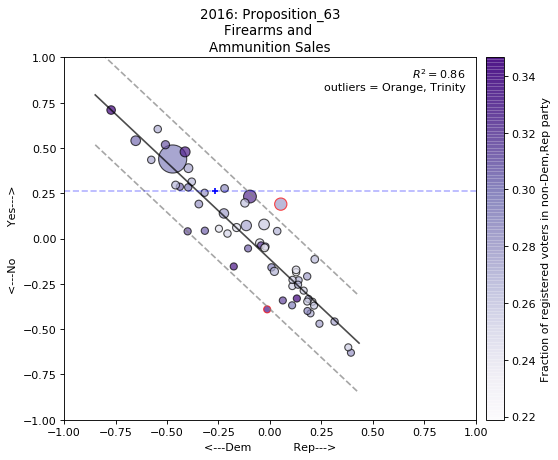

In [245]:
for ii in range(len(df_prop_meta)):
    if ii != 125: continue
    meta_row = df_prop_meta.iloc[ii]


    # get the proposition metadata
    prop_descr  = meta_row['Description']
    prop_date = meta_row.name[0]
    prop_name = meta_row.name[1]
    elec_type = meta_row['Election_type']
    reg_date = meta_row['nearest_reg_date']

    # grab the voter registration data and proposition voting results
    # make sure to drop the state results rows for plots and calcs
    vote_yes = df_prop.loc[df_prop.index != 'State Totals',idx[prop_date,prop_name,'Yes']]
    vote_no = df_prop.loc[df_prop.index != 'State Totals',idx[prop_date,prop_name,'No']]
    yes_no_asym = (vote_yes-vote_no)/(vote_yes+vote_no)
    reg_dem = df_reg.loc[idx[:,'Count'],idx[reg_date,'Democratic']].drop('State Total')
    reg_rep = df_reg.loc[idx[:,'Count'],idx[reg_date,'Republican']].drop('State Total')
    rep_dem_asym = (reg_rep-reg_dem)/(reg_rep+reg_dem)
    reg_frac = df_reg.loc[idx[:,'Fraction'],idx[reg_date,'Total Registered']].drop('State Total')
    reg_tot = df_reg.loc[idx[:,'Count'],idx[reg_date,'Total Registered']].drop('State Total')
    elg_tot = df_reg.loc[idx[:,'Count'],idx[reg_date,'Eligible']].drop('State Total')
    elg_norm = 1+(elg_tot - elg_tot.min())/ (elg_tot.max()-elg_tot.min())
    non_trad_party = (reg_tot - (reg_dem + reg_rep))/reg_tot
    vote_yes_state = df_prop.loc['State Totals',idx[prop_date,prop_name,'Yes']]
    vote_no_state = df_prop.loc['State Totals',idx[prop_date,prop_name,'No']]
    yes_no_asym_state = (vote_yes_state-vote_no_state)/(vote_yes_state+vote_no_state)
    reg_dem_state = df_reg.loc[idx['State Total','Count'],idx[reg_date,'Democratic']]
    reg_rep_state = df_reg.loc[idx['State Total','Count'],idx[reg_date,'Republican']]
    rep_dem_asym_state = (reg_rep_state-reg_dem_state)/(reg_rep_state+reg_dem_state)
    df_prop_meta.loc[idx[prop_date,prop_name],'std'] = yes_no_asym.std()
    
    # fit a line
    model_OLS = lm.LinearRegression()
    model_OLS.fit(rep_dem_asym.values.reshape(-1,1),yes_no_asym)
    X_line = np.linspace(1.1*rep_dem_asym.min(),1.1*rep_dem_asym.max(),num=20).reshape(-1,1)
    y_OLS = model_OLS.predict(X_line)
    R2 = model_OLS.score(rep_dem_asym.values.reshape(-1,1),yes_no_asym)
    df_prop_meta.loc[idx[prop_date,prop_name],'R2'] = R2
    resid_standardized = pd.Series(preproc.scale(resid),index = resid.index)
    resid_standardized['State Totals'] = 0
    df_prop.loc[:,idx[prop_date,prop_name,'residual']] = resid_standardized
    
    # find oultliers using interquartile range of the residuals distribution
    resid = yes_no_asym - model_OLS.predict(rep_dem_asym.values.reshape(-1,1))
    Q1, Q3 = np.percentile(resid,[25,75])
    IQR = Q3 - Q1
    lo_thresh, hi_thresh = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    is_outlier = (resid < lo_thresh) | (resid > hi_thresh)
    edgecolors = np.array(['k']*len(is_outlier))
    edgecolors[is_outlier.values] = 'r'
    outliers = is_outlier[is_outlier].index.values
    outliers_str = ', '.join([outlier for outlier in outliers])
    df_prop_meta.loc[idx[prop_date,prop_name],'outliers'] = outliers_str
    df_prop_meta.loc[idx[prop_date,prop_name],'num_outliers'] = len(outliers)
    is_outlier['State Totals'] = False
    df_prop.loc[:,idx[prop_date,prop_name,'is_outlier']] = is_outlier
    
    
    # show the line and scatter-plot
    plt.figure(figsize=(8, 6), dpi= 80)
    plt.plot(X_line,y_OLS,alpha=0.7,color='k')
    plt.plot(X_line,y_OLS+Q3+1.5*IQR,alpha=0.7,color='grey',linestyle='--')
    plt.plot(X_line,y_OLS+Q1-1.5*IQR,alpha=0.7,color='grey',linestyle='--')
    plt.plot([-1,1],[yes_no_asym_state]*2,alpha=0.3,color='blue',linestyle='--')
    h_scatter = plt.scatter(rep_dem_asym,yes_no_asym,marker='o',c=non_trad_party,s=40*elg_norm**4,
                cmap=plt.get_cmap('Purples'),alpha=0.7,edgecolor=edgecolors)
    plt.scatter(rep_dem_asym_state, yes_no_asym_state, c='blue', marker='+')
    plt.title(str(prop_date.year) + ': ' + prop_name + '\n' + prop_descr)
    plt.xlabel('<---Dem            Rep--->')
    plt.ylabel('<---No         Yes--->')
    if len(outliers) > 0:
        text_str = '$R^2 = ${:.2f}\noutliers = {:s}'.format(R2,outliers_str)
    else:
        text_str = '$R^2 = ${:.2f}'.format(R2)
    plt.text(x=.95,y=.95,s=text_str,ha='right',va='top')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    cbar = plt.colorbar(mappable=h_scatter,pad=0.02)
    cbar.ax.set_ylabel('Fraction of registered voters in non-Dem,Rep party')
    #plt.savefig('plots/'+str(prop_date.year)+'-'+prop_name+'.pdf')
    #plt.clf()
    
df_prop.sort_index(axis=1,level=[0,1,2],inplace=True)
df_prop_meta.sort_index(axis=1,level=1,inplace=True)

In [154]:
df_prop

Date                2002-03-05                                               \
Proposition     Proposition_40                               Proposition_41   
Votes                       No      Yes is_outlier  residual             No   
Alameda                  74228   142873      False -0.354435          81464   
Alpine                     256      281      False -0.447048            296   
Amador                    5883     3605      False -0.113038           5888   
Butte                    25178    21833      False -0.305752          24582   
Calaveras                 7642     4923      False -0.154831           7642   
Colusa                    2931     1322      False -0.265209           2679   
Contra Costa             74344   103748      False  0.662764          79849   
Del Norte                 3625     1903      False -1.335640           3419   
El Dorado                24884    16872      False  0.822960          25075   
Fresno                   53206    53571      False  0.306269          50762   
Glenn                     3706     1155      False -0.731205           3225   
Humboldt                 16576    15093      False -1.501790          16216   
Imperial                  7478     9210      False -0.560458           8560   
Inyo                      3297     2217      False  0.278765           3100   
Kern                     50046    37754      False -0.362933          57589   
Kings                     8046     5821      False  0.536448           7932   
Lake                      5881     5372      False -1.894024           6102   
Lassen                    5065     2351      False -0.791283           4622   
Los Angeles             347804   633273      False  0.403062         414154   
Madera                   12143     6565      False  0.029177          11473   
Marin                    19960    42222      False  1.131426          22778   
Mariposa                  3389     2041      False -0.223335           3356   
Mendocino                 7298     8709      False -2.272720           9841   
Merced                   14019    12509      False -0.652774          14501   
Modoc                     2416      735      False -0.659806           2085   
Mono                      1336     1048      False  0.255614           1330   
Monterey                 24857    34555      False  0.180820          29173   
Napa                     11144    15315      False  0.230695          11884   
Nevada                   17307    12884      False  0.390845          17329   
Orange                  216770   270153      False  3.001830         264208   
Placer                   39972    28446      False  1.936616          40883   
Plumas                    4592     2375      False -0.331802           4050   
Riverside                79428    96961      False  1.346304          85048   
Sacramento               99742   111800      False  0.118341         110100   
San Benito                4304     4767      False -0.800752           4601   
San Bernardino           79307    84686      False  0.528362          83797   
San Diego               191832   233412      False  2.018458         209148   
San Francisco            31184   111530      False -0.007453          37935   
San Joaquin              43571    43405      False  0.016957          45385   
San Luis Obispo          29788    26212      False  1.606320          30345   
San Mateo                40094    73921      False  0.747185          43941   
Santa Barbara            35037    35126      False  1.294008          35937   
Santa Clara              90006   141914      False  1.267691         101621   
Santa Cruz               18756    36009      False -0.559965          25112   
Shasta                   25445    11588      False -0.069793          23512   
Sierra                     973      473      False -0.754335            950   
Siskiyou                  9035     3285      False -1.158013           7978   
Solano                   27106    31100      False

In [155]:
df_prop_meta

Description  \
Date       Proposition                                                          
2002-03-05 Proposition_40       Clean Water/Air, Safe Parks, Coast Protection   
           Proposition_41               Voting Modernization Bond Act of 2002   
           Proposition_42      Transportation Funding: Sales/Use Tax Revenues   
           Proposition_43                          Right to have vote counted   
           Proposition_44                                     Insurance Fraud   
           Proposition_45     Legislative Term Limits. Local Voter Petitions.   
2002-11-05 Proposition_46            Housing and Emergency Shelter Trust Fund   
           Proposition_47             Kindergarten-University Facilities Bond   
           Proposition_48                                 Court Consolidation   
           Proposition_49                 After School Programs. State Grants   
           Proposition_50     Water Quality, Supply/Safe Drinking Water Bonds   
           Proposition_51   Transportation. Allocation of Motor Vehicle Taxes   
           Proposition_52                     Election Day Voter Registration   
2003-10-07 Proposition_53                             Infrastructure: Finance   
           Proposition_54         Classification by Race, ... Color or Origin   
2004-03-02 Proposition_55                                      Education Bond   
           Proposition_56                                        State Budget   
           Proposition_57                              Economic Recovery Bond   
           Proposition_58                                     Balanced Budget   
2004-11-02 Proposition_1A             Protection of Local Government Revenues   
           Proposition_59                       Public Records, Open Meetings   
           Proposition_60                Election Rights of Political Parties   
           Proposition_60A                                  Surplus Property.   
           Proposition_61        Children's Hospital Projects. Grant Program.   
           Proposition_62                                Elections. Primaries   
           Proposition_63                   Mental Health Services Expansion.   
           Proposition_64      Limits on Private Enforcement of Business Laws   
           Proposition_65    Local Government Funds, Revenues. State Mandates   
           Proposition_66                  Limitations on "Three Strikes" Law   
           Proposition_67                Emergency Medical Services. Funding.   
...                                                                       ...   
2012-11-06 Proposition_37               Genetically Engineered Foods Labeling   
           Proposition_38         Tax for Education. Early Childhood Programs   
           Proposition_39                     Business Tax for Energy Funding   
           Proposition_40                         Redistricting State\nSenate   
2014-06-03 Proposition_41      Veterans Housing\n& Homeless\nBond Act of 2014   
           Proposition_42    Public Records.\nOpen Meetings.\nReimbursements.   
2014-11-04 Proposition_1    Funding Water Quality, \nSupply, Treatment,\n ...   
           Proposition_2                  State Budget\nStabilization Account   
           Proposition_45                 Healthcare\nInsurance Rate\nChanges   
           Proposition_46           Doctor Drug Testing,\nMedical\nNegligence   
           Proposition_47         Criminal Sentences,\nMisdemeanor\nPenalties   
           Proposition_48                   Indian Gaming Compacts Referendum   
2016-06-07 Proposition_50                        Suspension \nof Legislators.   
2016-11-08 Proposition_51               K-12 and Community College Facilities   
           Proposition_52                       Medi-Cal Hospital Fee Program   
           Proposition_53                   Voter Approval of \nRevenue Bonds   
           Proposition_54                  Legislative Procedure Requirements   
           Propo

,,Description,Election_type,R2,nearest_reg_date,num_outliers,outliers,std,Descr_has_tax,Descr_has_health,Descr_has_school,Descr_has_insurance,Descr_has_gun,Descr_has_energy,Descr_has_environment,Descr_has_water,Descr_has_clean,Descr_has_bond
Date,Proposition,,,,,,,,,,,,,,,,,
2016-11-08,Proposition_63,Firearms and \nAmmunition Sales,general-election,0.858436,2016-10-24 00:00:00,2.0,"Orange, Trinity",0.322086,False,False,False,False,True,False,False,False,False,False


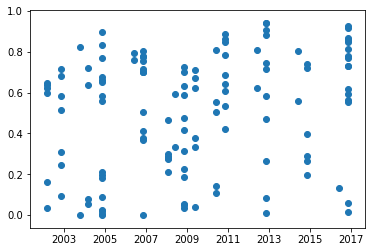

In [244]:
x = df_prop_meta.index.get_level_values(0)
#x = df_prop_meta['std']
y = df_prop_meta['R2']
plt.scatter(x,y)
df_prop_meta.query('std > .3')

In [178]:
df_prop_meta.query('R2 < .15')

Description  \
Date       Proposition                                                         
2002-03-05 Proposition_42     Transportation Funding: Sales/Use Tax Revenues   
2002-11-05 Proposition_49                After School Programs. State Grants   
2003-10-07 Proposition_53                            Infrastructure: Finance   
2004-03-02 Proposition_57                             Economic Recovery Bond   
           Proposition_58                                    Balanced Budget   
2004-11-02 Proposition_1A            Protection of Local Government Revenues   
           Proposition_62                               Elections. Primaries   
           Proposition_65   Local Government Funds, Revenues. State Mandates   
           Proposition_68           Non-Tribal Commercial Gambling Expansion   
           Proposition_70    Tribal Gaming Compacts. Exclusive Gaming Rights   
2006-11-07 Proposition_1A                Transportation Funding Protection\n   
2008-11-04 Proposition_11                                      Redistricting   
           Proposition_6     Police, Law Enforcement Funding. Criminal Laws.   
           Proposition_7                         Renewable Energy Generation   
2009-05-19 Proposition_1F  Elected                        Officials Salaries   
2010-06-08 Proposition_13   Property Taxes and Seismic Retrofit of Buildings   
           Proposition_14                     Primary Election Participation   
2012-11-06 Proposition_31          State Budget, State\nand Local Government   
           Proposition_35                                Human \nTrafficking   
2016-06-07 Proposition_50                       Suspension \nof Legislators.   
2016-11-08 Proposition_54                 Legislative Procedure Requirements   
           Proposition_60                     Adult Film Condom Requirements   

                                               Election_type        R2  \
Date       Proposition                                                   
2002-03-05 Proposition_42                   primary-election  0.034945   
2002-11-05 Proposition_49                   general-election  0.092755   
2003-10-07 Proposition_53         statewide-special-election  0.002532   
2004-03-02 Proposition_57      presidential-primary-election  0.056190   
           Proposition_58      presidential-primary-election  0.077112   
2004-11-02 Proposition_1A      presidential-general-election  0.088953   
           Proposition_62      presidential-general-election  0.000678   
           Proposition_65      presidential-general-election  0.003347   
           Proposition_68      presidential-general-election  0.025517   
           Proposition_70      presidential-general-election  0.019149   
2006-11-07 Proposition_1A                   general-election  0.000003   
2008-11-04 Proposition_11      presidential-general-election  0.051956   
           Proposition_6       presidential-general-election  0.032680   
           Proposition_7       presidential-general-election  0.050619   
2009-05-19 Proposition_1F         statewide-special-election  0.038173   
2010-06-08 Proposition_13  statewide-direct-primary-election  0.141422   
           Proposition_14  statewide-direct-primary-election  0.109209   
2012-11-06 Proposition_31                   general-election  0.085348   
           Proposition_35                   general-election  0.011216   
2016-06-07 Proposition_50      presidential-primary-election  0.134488   
2016-11-08 Proposition_54                   general-election  0.013035   
           Proposition_60                   general-election  0.060437   

                              nearest_reg_date  num_outliers  \
Date       Proposition                                         
2002-03-05 Proposition_42  2002-02-19 00:00:00           0.0   
2002-11-05 Proposition_49  2002-10-21 00:00:00           0.0   
2003-10-07 Proposition_53  2003-09-30 00:00:00           0.0   
2004-03-02 Proposition_57  2004-02-17 00:00:00 

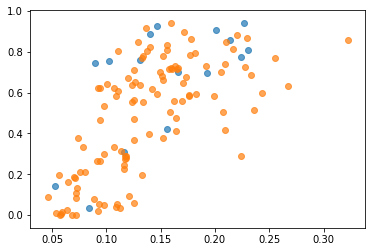

In [172]:
df_prop_meta['Descr_has_tax'] = df_prop_meta['Description'].map(lambda x: 'Tax' in x or 'tax' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_tax'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_tax'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_tax'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_tax'],'R2']
plt.scatter(x1,y1,alpha=0.7)
plt.scatter(x2,y2,alpha=0.7)


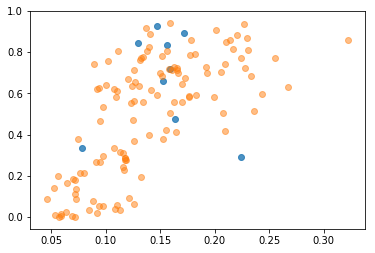

In [181]:
df_prop_meta['Descr_has_health'] = df_prop_meta['Description'].map(lambda x:
                                                                   'Health' in x or
                                                                   'care' in x or 'Hospital' in x or 'Treatment' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_health'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_health'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_health'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_health'],'R2']
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)

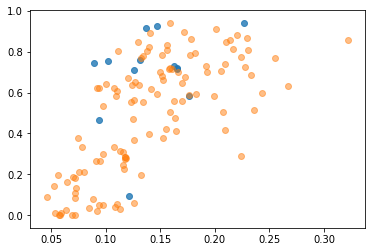

In [242]:
df_prop_meta['Descr_has_school'] = df_prop_meta['Description'].map(lambda x:
                                                                   'school' in x or
                                                                   'School' in x or
                                                                   'education' in x or
                                                                   'Education' in x or 
                                                                   'College' in x or 
                                                                   'college' in x or 
                                                                   'universit' in x or 
                                                                   'Universit' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_school'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_school'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_school'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_school'],'R2']
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)

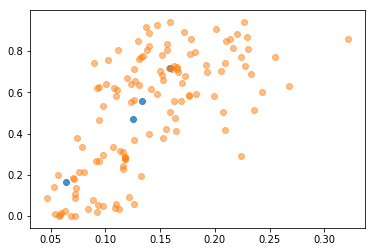

In [233]:
df_prop_meta['Descr_has_insurance'] = df_prop_meta['Description'].map(lambda x:
                                                                   'Insurance' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_insurance'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_insurance'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_insurance'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_insurance'],'R2']
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)

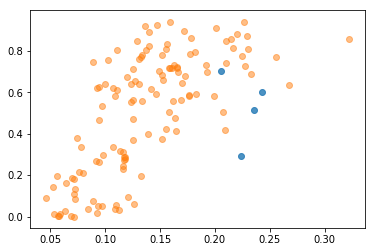

In [240]:
df_prop_meta['Descr_has_water'] = df_prop_meta['Description'].map(lambda x:
                                                                       'Water' in x or
                                                                       'water' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_water'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_water'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_water'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_water'],'R2']
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)

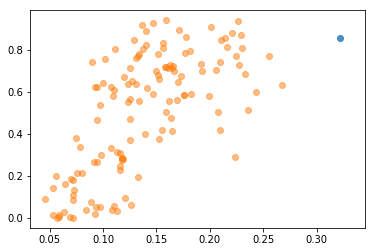

In [235]:
df_prop_meta['Descr_has_gun'] = df_prop_meta['Description'].map(lambda x:
                                                                       'Gun' in x or
                                                                       'gun' in x or
                                                                   'firearm' in x or
                                                                   'Firearm' in x or
                                                                    'Weapon' in x or
                                                                    'weapon' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_gun'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_gun'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_gun'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_gun'],'R2']
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)

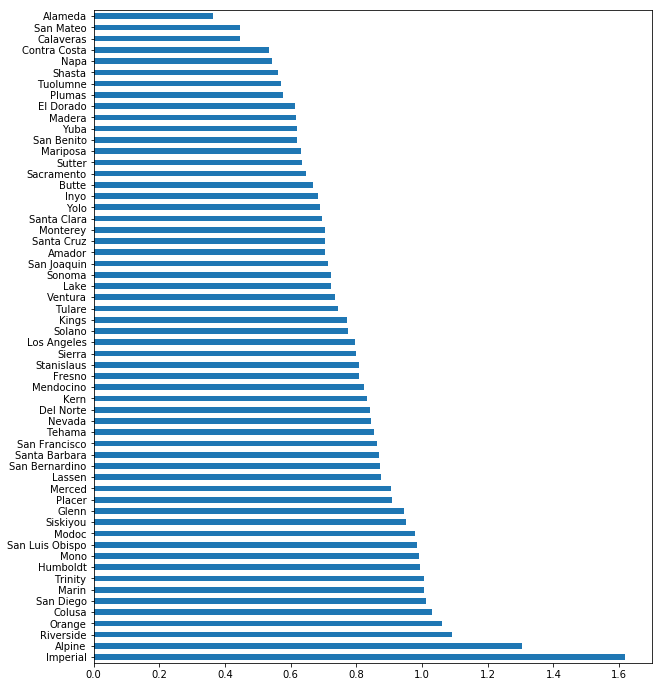

In [232]:
plt.figure(figsize=(10, 12))
np.abs(df_prop.loc[df_prop.index != 'State Totals',
                   idx[:,:,'residual']]).T.mean().sort_values(ascending=False).plot(kind='barh')

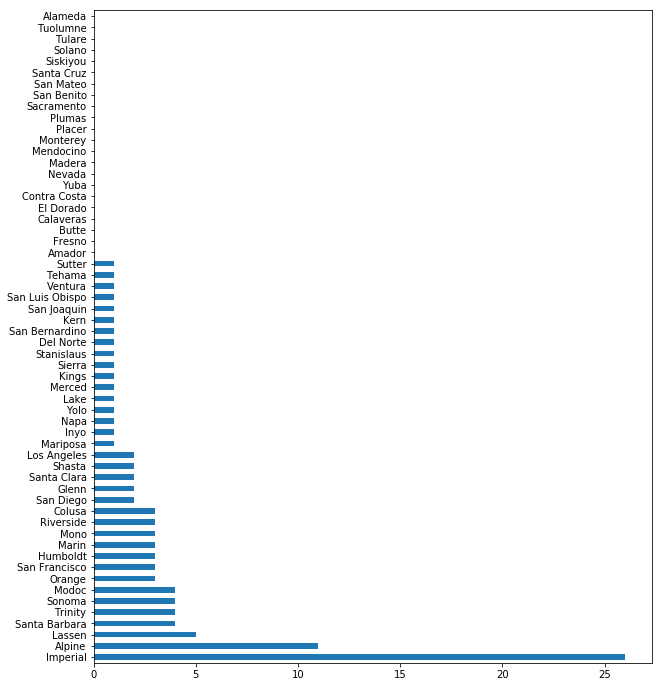

In [214]:
plt.figure(figsize=(10, 12))
(df_prop.loc[df_prop.index != 'State Totals',idx[:,:,'is_outlier']]).T.sum().sort_values(ascending=False).plot(kind = 'barh')

In [243]:
SF_outliers = df_prop.loc['Santa Barbara',idx[:,:,'is_outlier']]
SF_outliers.index = SF_outliers.index.droplevel(2)
df_prop_meta.loc[SF_outliers[SF_outliers].index,:]

Description  \
Date       Proposition                                                         
2002-11-05 Proposition_51  Transportation. Allocation of Motor Vehicle Taxes   
           Proposition_52                    Election Day Voter Registration   
2008-11-04 Proposition_7                         Renewable Energy Generation   
2009-05-19 Proposition_1D              Children's           Services Funding   

                                           Election_type        R2  \
Date       Proposition                                               
2002-11-05 Proposition_51               general-election  0.310240   
           Proposition_52               general-election  0.682461   
2008-11-04 Proposition_7   presidential-general-election  0.050619   
2009-05-19 Proposition_1D     statewide-special-election  0.379779   

                              nearest_reg_date  num_outliers  \
Date       Proposition                                         
2002-11-05 Proposition_51  2002-10-21 00:00:00           2.0   
           Proposition_52  2002-10-21 00:00:00           3.0   
2008-11-04 Proposition_7   2008-10-20 00:00:00           4.0   
2009-05-19 Proposition_1D  2009-05-04 00:00:00           1.0   

                                                        outliers       std  \
Date       Proposition                                                       
2002-11-05 Proposition_51                   Glenn, Santa Barbara  0.116218   
           Proposition_52        Modoc, Riverside, Santa Barbara  0.151463   
2008-11-04 Proposition_7   Alpine, Imperial, Mono, Santa Barbara  0.097443   
2009-05-19 Proposition_1D                          Santa Barbara  0.074423   

                           Descr_has_tax  Descr_has_health  Descr_has_school  \
Date       Proposition                                                         
2002-11-05 Proposition_51           True             False             False   
           Proposition_52          False             False             False   
2008-11-04 Proposition_7           False             False             False   
2009-05-19 Proposition_1D          False             False             False   

                           Descr_has_insurance  Descr_has_gun  \
Date       Proposition                                          
2002-11-05 Proposition_51                False          False   
           Proposition_52                False          False   
2008-11-04 Proposition_7                 False          False   
2009-05-19 Proposition_1D                False          False   

                           Descr_has_energy  Descr_has_environment  \
Date       Proposition                                               
2002-11-05 Proposition_51             False                  False   
           Proposition_52             False                  False   
2008-11-04 Proposition_7               True                  False   
2009-05-19 Proposition_1D             False                  False   

                           Descr_has_water  Descr_has_clean  Descr_has_bond  
Date       Proposition                                                       
2002-11-05 Proposition_51            False            False           False  
           Proposition_52            False            False           False  
2008-11-04 Proposition_7             False            False           False  
2009-05-19 Proposition_1D            False            False           False